## IMPORT LIBRARIES

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,LSTM
import IPython.display as ipd
import json
import pretty_midi
import fluidsynth

## PATH TO SAMPLE, TRAINING AND TEST DATA

In [2]:
MUSIC_TRAIN_PATH = 'train/maestro-v3.0.0'
MUSIC_TEST_PATH = 'test/maestro-v3.0.0'
MUSIC_TEST_OUTPUT = 'output'
MUSIC_SAMPLE_PATH = 'sample'
JSON_DATA_FILE = 'processed_data.json'

## MODEL PARAMETERS

In [3]:
HIDDEN_STATE_SIZE = 128
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
DECAY_RATE = 1e-5
LOSS_FN = 'categorical_crossentropy'
METRICS = ['accuracy']
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2
VALIDATION_SPLIT = 0.2

## LOAD TRAINING DATA AND PARAMETERS FROM JSON FILE

In [4]:
train_data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    train_data = json.loads(json.load(json_data_file))

X_train = np.array(train_data['input'])
y_train = np.array(train_data['output'])
train_note_velocity_mean_var = train_data['note_velocities_mean_var']
train_token_to_notes = train_data['tokens_to_notes_dict']

In [5]:
NUM_UNIQUE_NOTES = train_data['num_unique_notes']
KEY_FPS = train_data['key_fps']
HOP_LENGTH = train_data['hop_length']
WINDOW_SIZE_IN_KEYS = train_data['windows_size_in_keys']
SAMPLE_RATE = KEY_FPS * HOP_LENGTH
FRAME_SIZE = WINDOW_SIZE_IN_KEYS * HOP_LENGTH
MAX_PIANO_FREQ = train_data['max_piano_freq']

In [6]:
print(X_train.shape)
print(y_train.shape)

(1, 7757, 2048)
(1, 7757)


## LOAD TEST DATA

In [7]:
test_data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    test_data = json.loads(json.load(json_data_file))

X_test = np.array(test_data['input'])
y_test = np.array(test_data['output'])
test_note_velocity_mean_var = test_data['note_velocities_mean_var']
test_token_to_notes = test_data['tokens_to_notes_dict']

In [8]:
print(X_test.shape)
print(y_test.shape)

(1, 7757, 2048)
(1, 7757)


## CONVERT OUTPUT LABEL AT EACH TIME-STEP TO ONE-HOT ENCODING

In [9]:
def convert_label_to_one_hot(output_labels):
    output_one_hot = []
    for sample in range(output_labels.shape[0]):
        sample_output = output_labels[sample,:]
        sample_output_one_hot = np.zeros((sample_output.size, sample_output.max()+1))
        sample_output_one_hot[np.arange(sample_output.size), sample_output] = 1
        output_one_hot.append(sample_output_one_hot)
    
    return np.array(output_one_hot)

In [10]:
y_train = convert_label_to_one_hot(y_train)
y_test = convert_label_to_one_hot(y_test)

In [11]:
print(y_train.shape)
print(y_test.shape)

(1, 7757, 1505)
(1, 7757, 1505)


## ENCODER DECODER NETWORK

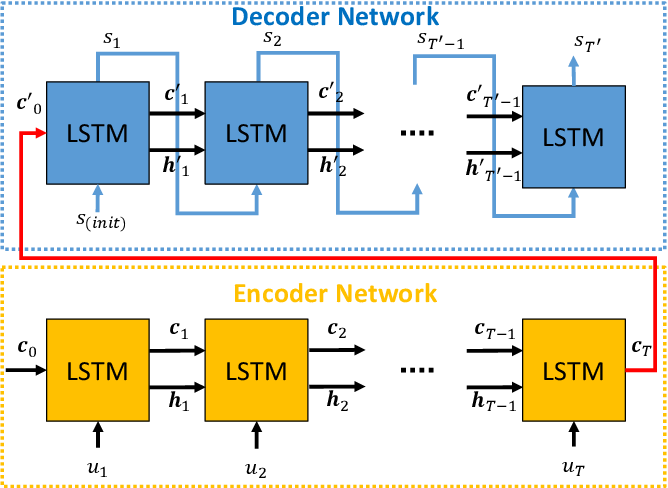

In [12]:
ipd.Image("images/encoder_decoder.png", width=900, height=540)

## SPECIFY MODEL ARCHITECTURE

In [68]:
encoder_inputs = Input(shape=(None, MAX_PIANO_FREQ))
encoder = LSTM(HIDDEN_STATE_SIZE, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, NUM_UNIQUE_NOTES))
decoder_lstm = LSTM(HIDDEN_STATE_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(NUM_UNIQUE_NOTES, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1505)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm_2 (LSTM)                  [(None, 128),        1114624     ['input_7[0][0]']                
                                 (None, 128),                                              

## CHOOSE OPTIMIZER AND COMPILE MODEL

In [69]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE)
model.compile(loss=LOSS_FN, optimizer=optimizer, metrics=METRICS)

## TRAIN MODEL

In [70]:
decoder_target_data = np.concatenate((np.zeros((y_train.shape[0], 1, y_train.shape[2])), y_train), axis=1)[:,:-1,:]
model.fit([X_train, y_train], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          #validation_split=VALIDATION_SPLIT
)

Epoch 1/10
1/1 [==============================] - 30s 30s/step - loss: 7.3161 - accuracy: 5.1566e-04
Epoch 2/10
1/1 [==============================] - 25s 25s/step - loss: 7.3112 - accuracy: 0.0031
Epoch 3/10
1/1 [==============================] - 23s 23s/step - loss: 7.3063 - accuracy: 0.0534
Epoch 4/10
1/1 [==============================] - 23s 23s/step - loss: 7.3013 - accuracy: 0.1120
Epoch 5/10
1/1 [==============================] - 25s 25s/step - loss: 7.2959 - accuracy: 0.1422
Epoch 6/10
1/1 [==============================] - 24s 24s/step - loss: 7.2898 - accuracy: 0.1570
Epoch 7/10
1/1 [==============================] - 25s 25s/step - loss: 7.2825 - accuracy: 0.1435
Epoch 8/10
1/1 [==============================] - 25s 25s/step - loss: 7.2728 - accuracy: 0.1129
Epoch 9/10
1/1 [==============================] - 25s 25s/step - loss: 7.2577 - accuracy: 0.0901
Epoch 10/10
1/1 [==============================] - 24s 24s/step - loss: 7.2271 - accuracy: 0.0886


## INFERENCE MODEL

In [72]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 2048)]      0         
                                                                 
 lstm_2 (LSTM)               [(None, 128),             1114624   
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 1,114,624
Trainable params: 1,114,624
Non-trainable params: 0
_________________________________________________________________


In [76]:
decoder_state_input_h = Input(shape=(HIDDEN_STATE_SIZE,), name="input_3")
decoder_state_input_c = Input(shape=(HIDDEN_STATE_SIZE,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [77]:
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_outputs = decoder_dense(decoder_outputs)

In [78]:
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, 1505)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, None, 128),  836608      ['input_8[0][0]',         

## INFERENCE

In [108]:
def decode_sequence(input_seq, encoder_model, decoder_model, batch_size=BATCH_SIZE):
    # Shape of target sequence : (BATCH_SIZE, NUM_TIME_STEPS, NUM_UNIQUE_NOTES)

    states = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, NUM_UNIQUE_NOTES))
    output_seq = []
    time_step = 0
    
    while time_step < input_seq.shape[1]:
        output_current, h, c = decoder_model.predict([target_seq, states[0], states[1]])
        output_note_indx = np.argmax(output_current[0, -1, :])
        output_seq.append(output_current)

        target_seq = np.zeros((1, 1, NUM_UNIQUE_NOTES))
        target_seq[0, 0, output_note_indx]=1
        
        states = [h, c]
        time_step += 1

    output_seq = np.array(output_seq, shape=(input_seq.shape[0], input_seq.shape[1], NUM_UNIQUE_NOTES))
    return output_seq

In [109]:
output_seq = decode_sequence(X_test, encoder_model, decoder_model)
output_seq.shape

ValueError: in user code:

    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\amogh\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Exception encountered when calling layer "model_15" (type Functional).
    
    Layer "lstm_3" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 1505) dtype=float32>]
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 1, 1505), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)')
      • training=False
      • mask=None


## CONVERT PREDICTION TO MIDI

In [17]:
def convert_prediction_to_midi(indx, output, token_to_notes=test_token_to_notes, note_vel_mean_var=test_note_velocity_mean_var):
    assert (output.shape[-1] == NUM_UNIQUE_NOTES)
    notes_seq = [token_to_notes[str(x)] for x in output.argmax(1)]
    instrument = pretty_midi.Instrument(0, name='piano')
    note_details = {}
    pm = pretty_midi.PrettyMIDI()
    
    for index, note in enumerate(notes_seq):
        if note != '':
            notes = note.split(',')
            for i in notes:
                note_vel = np.random.normal(note_vel_mean_var[indx][0][int(i)], note_vel_mean_var[indx][1][int(i)])
                if int(i) not in note_details:
                    note_details[int(i)]=[[index], [index], [note_vel]]
                else:
                    if note_details[int(i)][1][-1]==(index-1):
                        note_details[int(i)][1][-1]=index
                    else:
                        note_details[int(i)][0].append(index)
                        note_details[int(i)][1].append(index)
                        note_details[int(i)][2].append(note_vel)

    for note in note_details:
        for start_time, end_time, note_velocity in zip(note_details[note][0], note_details[note][1], note_details[note][2]):
            pretty_note = pretty_midi.Note(
                velocity=int(note_velocity),
                pitch=note,
                start=start_time/KEY_FPS,
                end=end_time/KEY_FPS
            )
            instrument.notes.append(pretty_note)
    
    instrument.notes.sort(key=lambda x: x.start)
    pm.instruments.append(instrument)
    return pm

In [18]:
file_indx = 0
pmidi = convert_prediction_to_midi(file_indx, y_predict[file_indx])
pmidi.write(os.path.join(MUSIC_TEST_OUTPUT, test_data['filenames'][file_indx]+'.midi'))